## Task 3: Transfer Learning

In [1]:
import numpy as np
from tensorflow.keras.applications import ResNet50V2
import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout, Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import itertools
import math

from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline, test_data_Pipeline_non_normalized
from funcs_Task2_3 import plot_accuracy_loss, concat_generators, plot_confusion_matrix

2025-05-02 18:28:28.998662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-02 18:28:28.998780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-02 18:28:29.528162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# constants
img_height = img_width = 128
batch_size = 128
img_size = (img_height, img_width)

train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'

epochs=30


### 1. Classification Set-Up

In [3]:
np.random.seed(123)
tf.random.set_seed(123) 
metrics = ["accuracy"]

### 2. Setting Up the Base Model

In [4]:
# instantiate pre-trained model and freeze layers
ResNet_model = ResNet50V2(
    include_top=False,
    weights="imagenet",
)

ResNet_model.trainable = False

2025-05-02 18:29:21.788797: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:81:00.0, compute capability: 8.0


In [5]:
# add extra layers to model
inputs = Input(shape=(img_height, img_width, 3))
x = ResNet_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = keras.Model(
    inputs,
    outputs
)

# print architecture
model.summary(show_trainable = True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         Y          
                                                                            
 resnet50v2 (Functional)     (None, None, None, 2048   2356480   N          
                             )                         0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dense (Dense)               (None, 128)               262272    Y          
                                                                            
 dropout (Dropout)           (None, 128)               0     

### 3. Model Training

In [6]:
# compile model and fetch training and validation data
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

train_data_gen = training_data_Pipeline(batch_size, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(batch_size, img_size, test_dir = val_dir, train_dir = train_dir)

total_train=train_data_gen.samples
total_val = val_data_gen.samples

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [7]:
# train model
history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
)

Epoch 1/30


2025-05-02 18:29:59.683441: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-05-02 18:30:07.979702: I external/local_xla/xla/service/service.cc:168] XLA service 0x1523c6a969e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-02 18:30:07.979736: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-05-02 18:30:08.167935: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746203408.388736 1663859 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 [==============================] - 26s 1s/step - loss: 1.7914 - accuracy: 0.6288 - val_loss: 0.8745 - val_accuracy: 0.5450
Epoch 2/30
13/13 [==============================] - 7s 555ms/step - loss: 0.6438 - accuracy: 0.7444 - val_loss: 0.7133 - val_accuracy: 0.6025
Epoch 3/30
13/13 [==============================] - 6s 460ms/step - loss: 0.5048 - accuracy: 0.7681 - val_loss: 0.6245 - val_accuracy: 0.6250
Epoch 4/30
13/13 [==============================] - 6s 459ms/step - loss: 0.4582 - accuracy: 0.7681 - val_loss: 0.5795 - val_accuracy: 0.7175
Epoch 5/30
13/13 [==============================] - 6s 458ms/step - loss: 0.4010 - accuracy: 0.8181 - val_loss: 0.6005 - val_accuracy: 0.6975
Epoch 6/30
13/13 [==============================] - 6s 457ms/step - loss: 0.3945 - accuracy: 0.8144 - val_loss: 0.5825 - val_accuracy: 0.7250
Epoch 7/30
13/13 [==============================] - 6s 459ms/step - loss: 0.3864 - accuracy: 0.8106 - val_loss: 0.5548 - val_accuracy: 0.7275
Epoch 8/30
13/13 [=

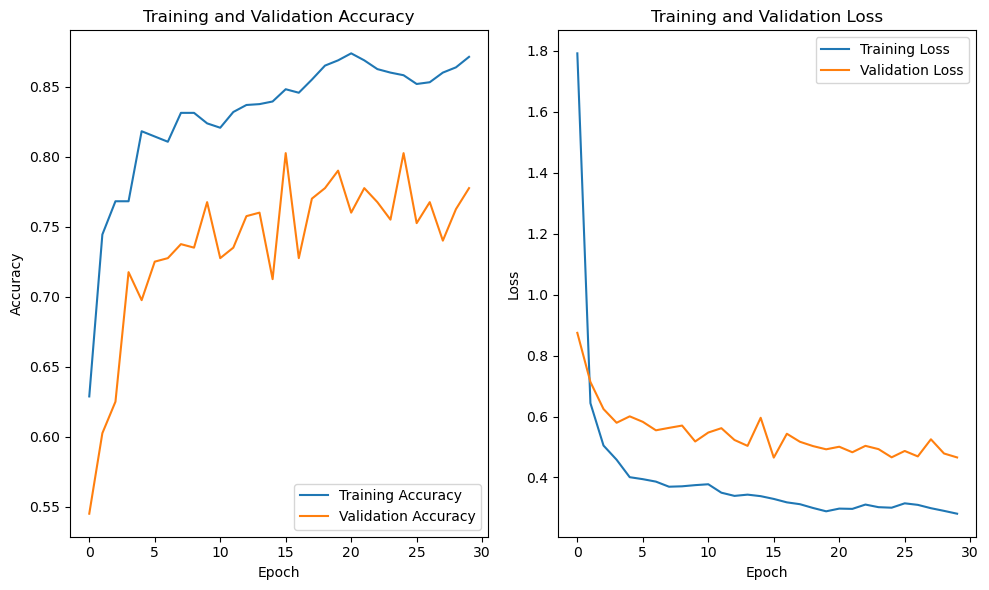

In [ ]:
plot_accuracy_loss(history, epochs)

### 4. Hyperparameter Tuning

In [9]:
tf.config.run_functions_eagerly(True)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tf.config.run_functions_eagerly(False)

In [10]:
def build_transfer_model(img_height, img_width, dr, lr, metrics, trainingResNet = False):
    inputs = Input(shape=(img_height, img_width, 3))
    x = ResNet_model(inputs, training = trainingResNet)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dr)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)

    model = keras.Model(
        inputs,
        outputs
    )

    optimizer = keras.optimizers.Adam(learning_rate = lr)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

    return model

In [11]:
# Loop over different combinations of hyperparameters
batch_sizes = [32, 64, 128]
learning_rates = [1e-2, 1e-3, 1e-4]
dropout_rates = [0.3, 0.4, 0.5]

results = []

for comb in itertools.product(batch_sizes, dropout_rates, learning_rates):
    batch_size = comb[0]
    dr = comb[1]
    lr = comb[2] 
    print(f'Start with batch size: {batch_size}, learning rate: {lr}, dropout rate: {dr}')

    model = build_transfer_model(img_height, img_width, dr, lr, metrics, trainingResNet = False)

    # Train model
    history = model.fit(
        train_data_gen,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=val_data_gen,
        callbacks = [early_stop],
        verbose = 0
    )

    # Collect results
    best_val_acc = max(history.history['val_accuracy'])
    amount_epochs = max(history.epoch)
    results.append({
        'batch_size': batch_size,
        'learning_rate': lr,
        'dropout_rate': dr,
        'val_accuracy': best_val_acc,
        'epochs': amount_epochs
    })

    print(f"Done: batch_size={batch_size}, lr={lr}, dr={dr}, val_acc={best_val_acc:.4f}, epochs={amount_epochs}")


df = pd.DataFrame(results)
df.to_csv("hyperparameter_tuning_results_task3_grid.csv", index=False)


Start with batch size: 32, learning rate: 0.01, dropout rate: 0.3
Done: batch_size=32, lr=0.01, dr=0.3, val_acc=0.7475, epochs=16
Start with batch size: 32, learning rate: 0.001, dropout rate: 0.3
Done: batch_size=32, lr=0.001, dr=0.3, val_acc=0.7900, epochs=26
Start with batch size: 32, learning rate: 0.0001, dropout rate: 0.3
Done: batch_size=32, lr=0.0001, dr=0.3, val_acc=0.7600, epochs=29
Start with batch size: 32, learning rate: 0.01, dropout rate: 0.4
Done: batch_size=32, lr=0.01, dr=0.4, val_acc=0.7575, epochs=21
Start with batch size: 32, learning rate: 0.001, dropout rate: 0.4
Done: batch_size=32, lr=0.001, dr=0.4, val_acc=0.7850, epochs=26
Start with batch size: 32, learning rate: 0.0001, dropout rate: 0.4
Done: batch_size=32, lr=0.0001, dr=0.4, val_acc=0.7675, epochs=29
Start with batch size: 32, learning rate: 0.01, dropout rate: 0.5
Done: batch_size=32, lr=0.01, dr=0.5, val_acc=0.7575, epochs=24
Start with batch size: 32, learning rate: 0.001, dropout rate: 0.5
Done: batch

### 5. Train your pre-trained model

In [12]:
# get data generators and specify hyperparameters (best performing from tuning)
training_data_gen = training_data_Pipeline(128, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(128, img_size, train_dir, val_dir)
full_data_gen = concat_generators(training_data_gen, val_data_gen)

total_train = train_data_gen.samples + val_data_gen.samples

best_run = df[df.val_accuracy == df.val_accuracy.max()]
learning_rate = best_run.learning_rate.iloc[0]
dropout_rate = best_run.dropout_rate.iloc[0]
batch_size = best_run.batch_size.iloc[0]
epochs = best_run.epochs.iloc[0]
best_val_acc = best_run.val_accuracy.iloc[0]

print(f"Best performing hyperparameters: batch size = {batch_size}, dropout rate = {dropout_rate}, learning rate = {learning_rate}, epochs ran = {amount_epochs}, val_acc={best_val_acc:.4f}")

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Best performing hyperparameters: batch size = 32, dropout rate = 0.5, learning rate = 0.001, epochs ran = 14, val_acc=0.7975


In [13]:
# train transfer model
transfer_model = build_transfer_model(
    img_height, img_width, 
    dropout_rate, learning_rate, 
    metrics, trainingResNet = False
)

history = transfer_model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch= math.ceil(total_train / batch_size),
    epochs=epochs
)

Epoch 1/18
63/63 [==============================] - 28s 409ms/step - loss: 0.6670 - accuracy: 0.7351
Epoch 2/18
63/63 [==============================] - 25s 404ms/step - loss: 0.3997 - accuracy: 0.7980
Epoch 3/18
63/63 [==============================] - 26s 405ms/step - loss: 0.3768 - accuracy: 0.8237
Epoch 4/18
63/63 [==============================] - 27s 428ms/step - loss: 0.3624 - accuracy: 0.8295
Epoch 5/18
63/63 [==============================] - 41s 658ms/step - loss: 0.3483 - accuracy: 0.8387
Epoch 6/18
63/63 [==============================] - 39s 614ms/step - loss: 0.3347 - accuracy: 0.8427
Epoch 7/18
63/63 [==============================] - 26s 411ms/step - loss: 0.3222 - accuracy: 0.8522
Epoch 8/18
63/63 [==============================] - 26s 414ms/step - loss: 0.3303 - accuracy: 0.8456
Epoch 9/18
63/63 [==============================] - 26s 409ms/step - loss: 0.3078 - accuracy: 0.8589
Epoch 10/18
63/63 [==============================] - 26s 409ms/step - loss: 0.3007 - accura

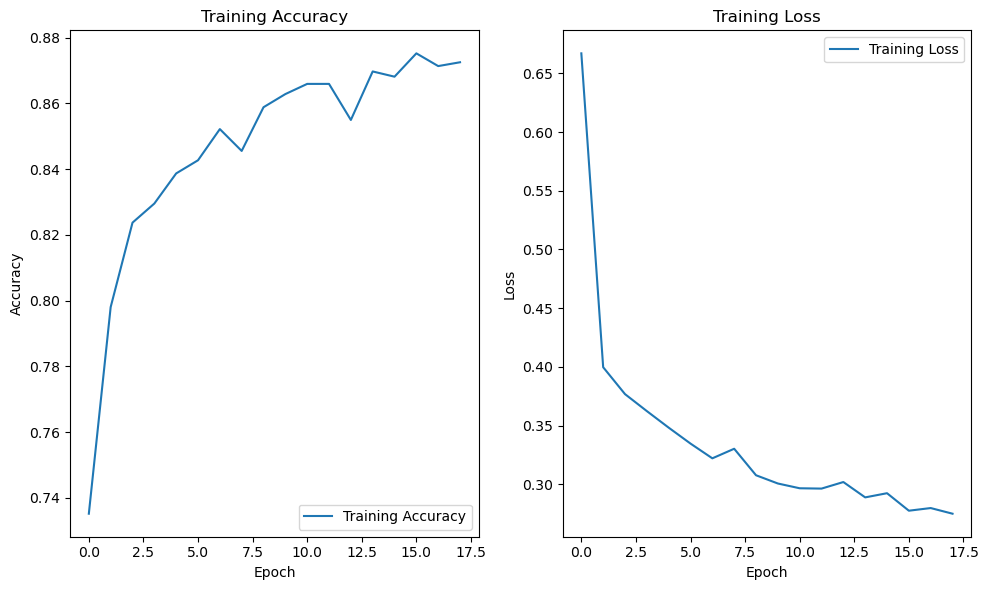

In [14]:
plot_accuracy_loss(history, epochs, validation = False)

In [15]:
model.save("ResNet_model.keras")
loaded_model = load_model("ResNet_model.keras")

### 6. Fine-tuning of the entire model

In [16]:
# retrain model with unfrozen ResNet part
loaded_model.get_layer("resnet50v2").trainable = True
loaded_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics= metrics)

history = loaded_model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch= math.ceil(total_train / batch_size),
    epochs=epochs
)
model.save("ResNet_finetuned_model.keras")

Epoch 1/18
63/63 [==============================] - 54s 473ms/step - loss: 1.1427 - accuracy: 0.5315
Epoch 2/18
63/63 [==============================] - 28s 440ms/step - loss: 0.7147 - accuracy: 0.5489
Epoch 3/18
63/63 [==============================] - 28s 444ms/step - loss: 0.5624 - accuracy: 0.7293
Epoch 4/18
63/63 [==============================] - 28s 440ms/step - loss: 0.4323 - accuracy: 0.8077
Epoch 5/18
63/63 [==============================] - 28s 440ms/step - loss: 0.3596 - accuracy: 0.8484
Epoch 6/18
63/63 [==============================] - 28s 440ms/step - loss: 0.3306 - accuracy: 0.8576
Epoch 7/18
63/63 [==============================] - 29s 458ms/step - loss: 0.2532 - accuracy: 0.8953
Epoch 8/18
63/63 [==============================] - 48s 769ms/step - loss: 0.2356 - accuracy: 0.9081
Epoch 9/18
63/63 [==============================] - 44s 698ms/step - loss: 0.2330 - accuracy: 0.9046
Epoch 10/18
63/63 [==============================] - 28s 446ms/step - loss: 0.1971 - accura

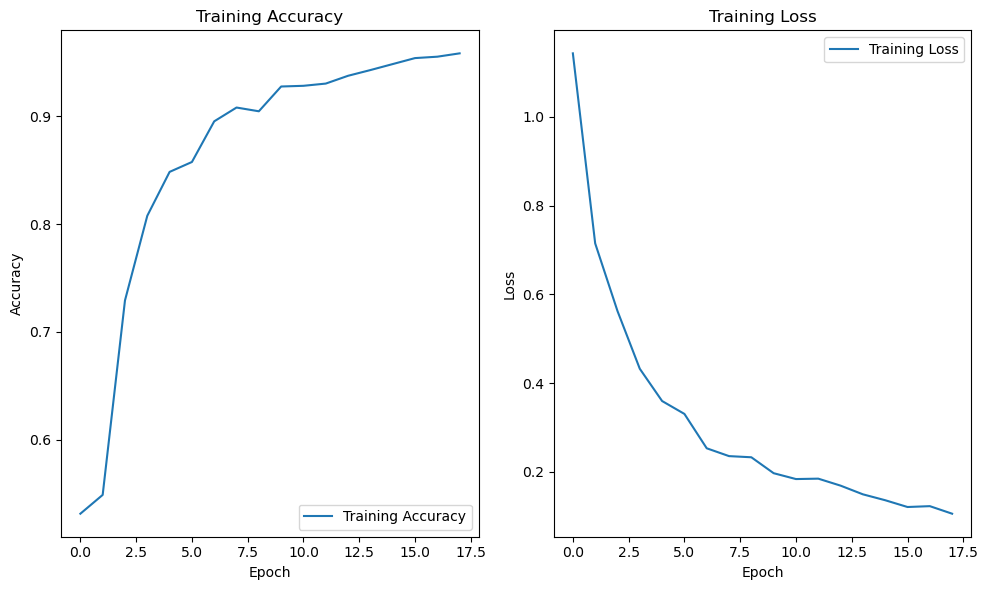

In [17]:
plot_accuracy_loss(history, epochs, validation = False)

In [18]:
final_model = load_model("ResNet_finetuned_model.keras")

In [19]:
## evaluate model based on test data
test_data_gen = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir)
loss, accuracy = final_model.evaluate(test_data_gen)

y_true = test_data_gen.classes
y_pred_probs = final_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(y_true, y_pred, target_names=test_data_gen.class_indices.keys()))

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
7/7 [==============================] - 1s 45ms/step
Test Loss: 0.5603
Test Accuracy: 0.7100
              precision    recall  f1-score   support

       COVID       0.49      0.43      0.46       100
      NORMAL       0.49      0.55      0.52       100

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.49      0.49      0.49       200



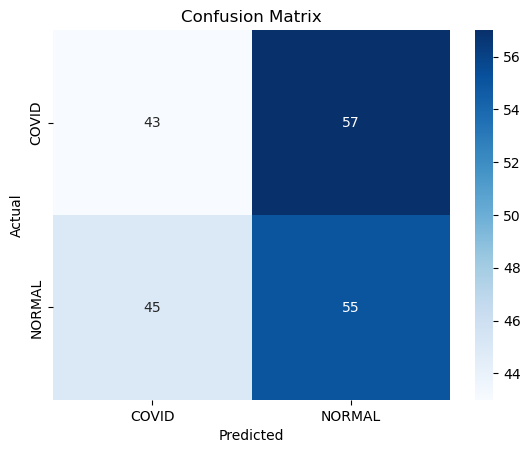

In [20]:
plot_confusion_matrix(y_true, y_pred, test_data_gen)

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
7/7 [==============================] - 0s 45ms/step
Found 200 images belonging to 2 classes.


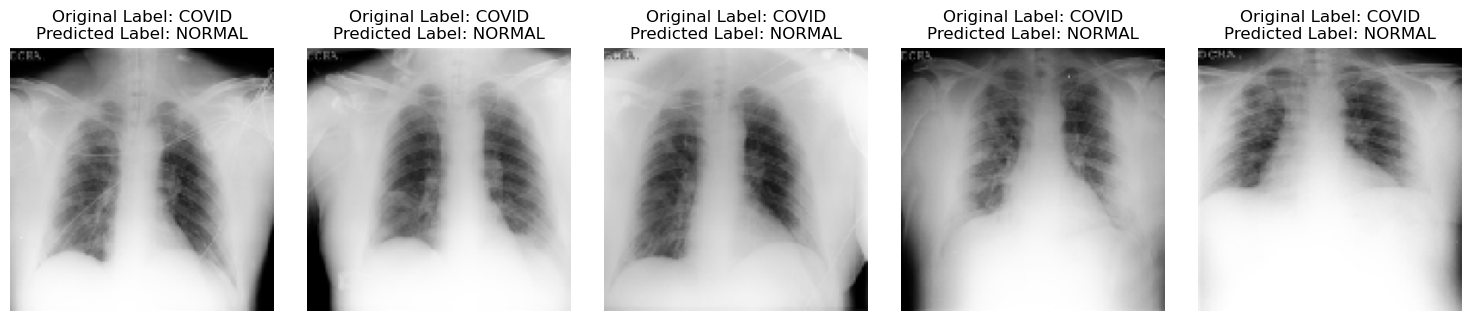

In [ ]:
# Plot a few samples from the test dataset without normalization with evaluation (after normalization)
# Get batch and process
## normalized 
test_data_gen_normalized  = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir, shuffle = False)
y_pred_probs = final_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
sample_images_normalized, sample_labels_normalized  = next(test_data_gen_normalized)

## non-normalized 
test_data_gen_non_normalized = test_data_Pipeline_non_normalized(batch_size, img_size, test_dir)
sample_images_non_normalized, sample_labels_non_normalized =  next(test_data_gen_non_normalized)

class_names = list(test_data_gen.class_indices.keys())

plt.figure(figsize=(15, 6))
for i, (img, label, pred) in enumerate(zip(sample_images_non_normalized[:5], sample_labels_non_normalized[:5], y_pred[:5])):
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original Label: {class_names[int(label)]}\nPredicted Label: {class_names[pred]}"), plt.axis('off')
    
plt.tight_layout()
plt.show()